# Homework 5 - Group 25
## Fabio Klinge, Tom Pieper & Niklas Laasch

# Imports

In [141]:
# Tensorflow Imports
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense


# Data Preparation Imports
import numpy as np
import pandas as pd


import time


# Multiprocessing Import
import multiprocessing as mp

In [142]:
VERBOSE = True
BATCH_SIZE = 4096
PREFETCH_SIZE = 2048
BUFFER_SIZE = 1024

# Check Gpu

In [143]:
tf.config.list_physical_devices('GPU')

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"


print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Load Data

In [144]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Data Pipeline

In [145]:
# Normalisation
train_images = train_images / 255.0
test_images = test_images / 255.0

In [146]:
# Reshaping
train_images = train_images.reshape(60000, 28, 28, 1)
test_images = test_images.reshape(10000, 28, 28, 1)

train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

In [147]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(PREFETCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(PREFETCH_SIZE)

# Layers:
---

## Feature Learning:
---
Convolution + Relu

Pooling

Convolution + Relu

Pooling

---

## Classification:
---
Flatten

Fully Connected

Softmax

---


# Model

In [148]:
#custom model with custom layer
class CustomModel(tf.keras.Model):
    
    # 
    def __init__(self):
        super(CustomModel, self).__init__()
        self.layer1 = Conv2D(64, (3,3), activation = 'relu', input_shape = (28,28,1))
        self.layer2 = MaxPooling2D(2,2)
        self.layer3 = Conv2D(64, (3,3), activation = 'relu')
        self.layer4 = MaxPooling2D(2,2)
        self.layer5 = Flatten()
        self.layer6 = Dense(128, activation = 'relu')
        self.out = Dense(10, activation = 'softmax')

    
    # cast the call-function as tf.function to increase efficiency
    @tf.function
    # pass the input through the layers of the network and return the output
    def call(self, inputs):
        x = self.layer1(inputs)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.out(x)
        return x

In [149]:
tf.keras.backend.clear_session()

# Training

## Train step & test

In [150]:
# compute the loss of an input for the model and optimize/tweak according the parameters
def train_step(model, input, target, loss_function, optimizer):
    # use tf.gradientTape to compute loss, then gradients and apply these to the model to modify the parameters
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


# compute the differences between or model prediction and the label, -> Supervision
def test(model, test_data, loss_function):
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=0) == np.argmax(prediction, axis=0)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))
    
# for all input and computed losses get the mean of accuracy and loss and return them
  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

## Training

In [151]:
#predefine learning-rate and epochs
num_epochs = 10
alpha = 0.1

# create a model
model = CustomModel()

# define loss-function and optimizer
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(alpha)

# create empty arrays to store test/accuracy values, to track the network progress
train_losses = []
test_losses = []
test_accuracies = []

# get initial accuracy- and loss valus before training starts
test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

train_loss, _ = test(model, train_ds, cross_entropy_loss)
train_losses.append(train_loss)

print("Starting Training: ")
# training loop
average_time = []
for epoch in range(num_epochs):
    # print accuracy of each epoch
    pre_train_time = time.time()
    print(f'Epoch: {str(epoch)} starting with accuracy {str(test_accuracies[-1])}')
    
    loss_epoch = []
    # for all input, do a forwardstep and obtain loss
    for input, target in train_ds:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        loss_epoch.append(train_loss)
    # get the mean loss of this epoch by using reduce_sum of TF over all input-losses and appending to the array  
    train_losses.append(tf.reduce_mean(loss_epoch))
    
    # get the losses and accuracy of this epoch and store them
    test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    average_time.append(time.time() - pre_train_time)
    print("Took: " + str(time.time() - pre_train_time))
    
# print accuracy after 10 epochs
print(test_accuracies[-1])
print("Mean Time per Epoch: " + str(round(np.mean(average_time), 2)) + "! With Parameters: ")
print("Batch size: " + str(BATCH_SIZE) + "  Prefetch size: " + str(PREFETCH_SIZE) + "  Buffer size: " + str(BUFFER_SIZE))
          
    

Starting Training: 
Epoch: 0 starting with accuracy tf.Tensor(0.0, shape=(), dtype=float64)
Took: 2.0889461040496826
Epoch: 1 starting with accuracy tf.Tensor(0.0, shape=(), dtype=float64)
Took: 1.9928171634674072
Epoch: 2 starting with accuracy tf.Tensor(0.0, shape=(), dtype=float64)
Took: 2.0003833770751953
Epoch: 3 starting with accuracy tf.Tensor(0.0, shape=(), dtype=float64)
Took: 2.090052366256714
Epoch: 4 starting with accuracy tf.Tensor(0.0, shape=(), dtype=float64)
Took: 2.0876405239105225
Epoch: 5 starting with accuracy tf.Tensor(0.0, shape=(), dtype=float64)
Took: 2.111520528793335
Epoch: 6 starting with accuracy tf.Tensor(0.0, shape=(), dtype=float64)
Took: 2.0068423748016357
Epoch: 7 starting with accuracy tf.Tensor(0.0, shape=(), dtype=float64)
Took: 1.9968342781066895
Epoch: 8 starting with accuracy tf.Tensor(0.0, shape=(), dtype=float64)
Took: 1.97149658203125
Epoch: 9 starting with accuracy tf.Tensor(0.0, shape=(), dtype=float64)
Took: 1.9526841640472412
tf.Tensor(0.03

# Visualisation

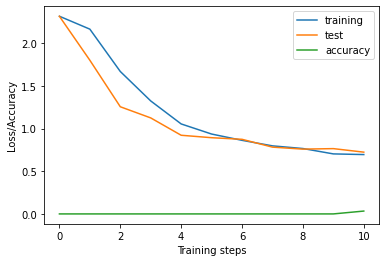

In [152]:
# Visualisation
import matplotlib.pyplot as plt

plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2,line3),("training","test", "accuracy"))
plt.show()